# Sequential Math Operations

Encoder - Decoder Model (GRU) for simple math operations (addition, substraction and multiplication) including priority brackets. Model was trained and tested on dataset which consisted of 50000 examples with character level prediction accuracy near 90%. However when tested its accuracy in predicting exact answers dropped to 70%.

TODO: retrain network on more complex expressions with more layers and better regularization <br>
TODO: implement integer division operator

In [1]:
#imports
import keras
import numpy as np
from numpy.random import randint, choice
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import math

# visualization
from termcolor import colored

In [70]:
# settings for RNN
OPERATORS = ['+', '-', '*']
CHARS = list(' 1234567890-+*/()')
MAX_SEQUENCE = 15
MAX_ANSWER = 4

In [3]:
# nodes are used to create expressions, eg. (1*4)
# or nested expressions eg. (1-3)*5
class Node:
    
    def __init__(self, left, right, operator):
        self.left = left
        self.right = right
        self.operator = operator
        
    # representation of node
    def __str__(self):
        return f'({self.left}{self.operator}{self.right})'

In [4]:
# encoder for tokenizing CHARS
class Encoder:
    
    def __init__(self, chars):
        self.chars = chars
        self.index_char = {k:v for k, v in enumerate(chars)}
        self.char_index = {v:k for k, v in enumerate(chars)}
        
    # encode multiple sequences into numbers
    def chars_numbers(self, chars):
        X = [[self.char_index[i] for i in seq] for seq in chars]
        return np.array(X)
    
    # decode multiple sequences into numbers
    def numbers_chars(self, numbers, strip=False):
        X = []
        for seq in numbers:
            x = ''.join([self.index_char[i] for i in seq])
            if strip:
                x = x.strip()
            X.append(x)
        return X
                
    # encode single sequence
    def encode_sequence(self, seq):
        return [self.char_index[i] for i in seq]
    
    # decode single sequence
    def decode_sequence(self, seq, strip=False):
        x = ''.join([self.index_char[i] for i in seq])
        if strip:
            x = x.strip()
        return x

In [5]:
def build_tree(num):
    
    '''
    functions used to create single expression
    
    num:    depth of recursion
    '''
    
    # if max depth is reached instead of expression return integer value
    if num < 2:
        return randint(1, 10)
    
    # randomly choose left and right node depth 
    num_left =  choice([i for i in range(num//2, num)])
    num_right = choice([i for i in range(num//2, num)])
    
    # generate subtrees and choose integer operator
    left_subtree = build_tree(num_left)
    right_subtree = build_tree(num_right)
    op = choice(OPERATORS)
    
    return Node(left_subtree, right_subtree, op)

In [71]:
def create_dataset(no_samples, low_interval=3, up_interval=4, 
                   strip_brackets=True, random_state=2018):
    
    '''
    function used to create dataset
    
    no_samples:      number of desired samples
    low_interval:    min boundary od depth in build_tree function
    up_interval:     max boundary od depth in build_tree function
    strip_brackets:  whether or not remove redundant brackets from expression (works only with small depths)
    random_state:    used to shuffle 
    '''
    
    # expressions and labels
    X, y = [], []
    
    # tqdm for visualization
    pbar = tqdm(total=no_samples)
    
    # counter for no. of expressions
    counter = 0
    
    while counter < no_samples:
        
        # choose random depth
        depth = randint(low_interval, up_interval)
        
        # if somehow sequence is longer than MAX_SEQUENCE then discard it and proceed to next iteration
        seq = str(build_tree(depth))
        if len(seq) > MAX_SEQUENCE:
            continue
        
        
        # evaluate sequence and check max length condition
        res = str(eval(seq))
        if len(res) > MAX_ANSWER:
            continue
            
        # stuff required when intoduciong division operator '/'
#         try:
#             res = str(eval(seq))
#             if len(res) > MAX_ANSWER:
#                 continue
                
#             seq = seq.replace('//', '/')
#         except ZeroDivisionError:
#             continue
            
        # remove redundant brackets from both sides
        if strip_brackets:
            seq = seq[1:-1]
        
        # append expression and value to proper datasets
        X.append(seq.ljust(MAX_SEQUENCE, ' '))
        y.append(res.ljust(MAX_ANSWER, ' '))
        
        # update counter and tqdm progress bar
        counter += 1
        pbar.update(1)
        
    # close progress bar
    pbar.close()
    
    # shuffle datasets
    X, y = shuffle(X, y, random_state=random_state)
    
    return X, y

In [72]:
# generate dataset
xs, ys = create_dataset(50000)

In [73]:
# create encoder 
encoder = Encoder(CHARS)

# encode datasets
x_data = encoder.chars_numbers(xs).reshape((len(xs), -1, 1))
y_data = encoder.chars_numbers(ys).reshape((len(ys), -1, 1))

In [74]:
# split data for training and testing datasets
train_size = 0.8
split = int(len(x_data) * train_size)
x_train, x_test = x_data[:split], x_data[split:]
y_train, y_test = y_data[:split], y_data[split:]

In [90]:
# create model in keras
# encoder part
inputs = keras.layers.Input(shape=x_train.shape[1:])
x = keras.layers.GRU(128, return_sequences=True)(inputs)
x = keras.layers.GRU(128)(x)
x = keras.layers.RepeatVector(MAX_ANSWER)(x)

# decoder part
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(CHARS), activation='softmax')(x)

# build and compile model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [187]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 15, 1)]           0         
_________________________________________________________________
gru_40 (GRU)                 (None, 15, 128)           50304     
_________________________________________________________________
gru_41 (GRU)                 (None, 128)               99072     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
gru_42 (GRU)                 (None, 4, 128)            99072     
_________________________________________________________________
gru_43 (GRU)                 (None, 4, 128)            99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 128)            0  

In [91]:
class CustomCallback(keras.callbacks.Callback):
    
    '''
    custom callback to track progress in training phase
    '''
    
    def on_epoch_end(self, epoch, logs=None):
        
        # print some stuff
        print()
        print('-'*60)
        print('epoch: ', epoch)
        print('equation\tpredicted\tactual\tresult')
        
        # choose 10 random exmaples from test dataset
        indexes = [randint(0, len(x_test)) for _ in range(10)]
        to_predict, labels = x_test[indexes], y_test[indexes]
        
        # test how network is performing on chosen examples
        for item, label in zip(to_predict, labels):
            
            # predict example
            yhat = model.predict(np.expand_dims(item, axis=0))
            result = np.argmax(yhat, axis=-1)[0]
            
            # reshape to 1D
            label = label.reshape(-1)
            item = item.reshape(-1)
            
            # decode both expression and value 
            decoded_predicted = encoder.decode_sequence(result)
            decoded_actual = encoder.decode_sequence(label)
            
            # print: equation, predicted value, actual value, result
            correct = decoded_predicted == decoded_actual
            correct = colored('True', 'green') if correct else colored('False', 'red')
            print(f'{encoder.decode_sequence(item)}\t{decoded_predicted}\t\t{decoded_actual}\t{correct}')
        print()
            
# create callback
callback = CustomCallback()

In [92]:
# train the model
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_split=0.2,
                    batch_size=64,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/30
500/500 [==============================] - 30s 53ms/step - loss: 1.4371 - accuracy: 0.5768 - val_loss: 1.2318 - val_accuracy: 0.6058

------------------------------------------------------------
epoch:  0
equation	predicted	actual	result
(5-4)+(3*3)    	1   		10  	False
(7*5)+3        	1   		38  	False
(7-9)+(4+7)    	1   		9   	False
6-1            	1   		5   	False
(4-4)-8        	1   		-8  	False
(5*7)-6        	1   		29  	False
(6*9)-(2+5)    	1   		47  	False
(6-3)-(6-3)    	1   		0   	False
3+(8+1)        	1   		12  	False
(8-9)-7        	1   		-8  	False

Epoch 2/30
500/500 [==============================] - 23s 46ms/step - loss: 1.2393 - accuracy: 0.6034 - val_loss: 1.2050 - val_accuracy: 0.6106

------------------------------------------------------------
epoch:  1
equation	predicted	actual	result
(7-2)-6        	1   		-1  	False
(4-1)-5        	1   		-2  	False
(8-7)-1        	1   		0   	False
3*(9+3)        	1   		36  	False
1+(8-2)        	1   		7   	False
(8*5)*

(1*8)*7        	56  		56  	True
3+(7*8)        	54  		59  	False
(5-4)+8        	9   		9   	True
(3+8)+2        	13  		13  	True

Epoch 14/30
500/500 [==============================] - 23s 47ms/step - loss: 0.4332 - accuracy: 0.8370 - val_loss: 0.3422 - val_accuracy: 0.8753

------------------------------------------------------------
epoch:  13
equation	predicted	actual	result
(4*1)-2        	2   		2   	True
6*8            	48  		48  	True
(4-5)-(6+1)    	-7  		-8  	False
(9*5)-(9*5)    	31  		0   	False
(5+5)+(3*4)    	20  		22  	False
(4*7)*8        	240 		224 	False
5+(9+9)        	24  		23  	False
8+(1-5)        	4   		4   	True
(7-1)-(9+1)    	-4  		-4  	True
8-(3*2)        	2   		2   	True

Epoch 15/30
500/500 [==============================] - 23s 46ms/step - loss: 0.4101 - accuracy: 0.8446 - val_loss: 0.4022 - val_accuracy: 0.8493

------------------------------------------------------------
epoch:  14
equation	predicted	actual	result
(7-1)-4        	2   		2   	True
5*(1+4)   

500/500 [==============================] - 23s 46ms/step - loss: 0.2944 - accuracy: 0.8913 - val_loss: 0.2415 - val_accuracy: 0.9117

------------------------------------------------------------
epoch:  25
equation	predicted	actual	result
5-(7*9)        	-50 		-58 	False
(5+3)*(1+2)    	24  		24  	True
(1-5)+6        	2   		2   	True
(1-9)*4        	-20 		-32 	False
(5-2)+9        	12  		12  	True
(1+6)-7        	0   		0   	True
4+(9+1)        	14  		14  	True
2*(4*5)        	46  		40  	False
(3-5)+2        	0   		0   	True
(1+6)-(4+4)    	-1  		-1  	True

Epoch 27/30
500/500 [==============================] - 23s 45ms/step - loss: 0.2924 - accuracy: 0.8933 - val_loss: 0.2907 - val_accuracy: 0.8864

------------------------------------------------------------
epoch:  26
equation	predicted	actual	result
(7-7)-(4-9)    	5   		5   	True
8+(5-8)        	5   		5   	True
8-(2-2)        	8   		8   	True
1+8            	9   		9   	True
5*3            	15  		15  	True
6+(1*6)        	13  		12  

<Figure size 720x720 with 0 Axes>

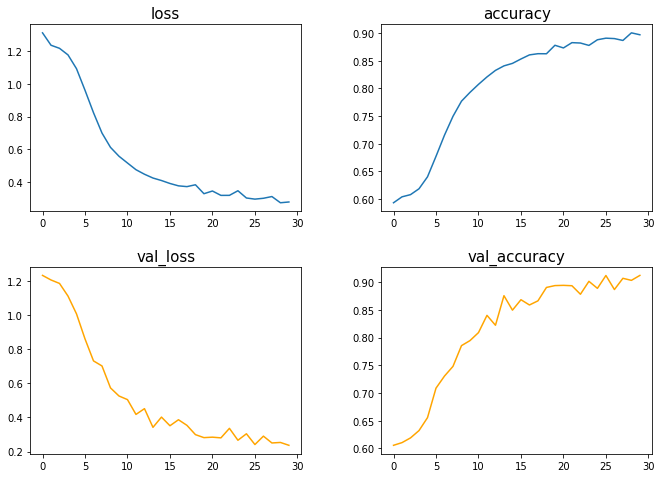

In [101]:
# plot loss and accuracy during training phase
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(10)

axs[0,0].set_title('loss', fontsize=15)
axs[0,0].plot(history.history['loss'])

axs[0,1].set_title('accuracy', fontsize=15)
axs[0,1].plot(history.history['accuracy'])

axs[1,0].set_title('val_loss', fontsize=15)
axs[1,0].plot(history.history['val_loss'], color='orange')

axs[1,1].set_title('val_accuracy', fontsize=15)
axs[1,1].plot(history.history['val_accuracy'], color='orange')
plt.show()

In [102]:
# print model results
loss, acc = model.evaluate(x_test, y_test)
print(f'model test loss:\t{round(loss, 4)}\n'
      f'model accuracy:\t\t{round(acc, 4)}')

313/313 [==============================] - 3s 8ms/step - loss: 0.2516 - accuracy: 0.9048
model test loss:	0.2516
model accuracy:		0.9048


In [104]:
# predict on test set to print errors
y_pred = model.predict(x_test)
y_hat = np.argmax(y_pred, axis=-1).reshape((len(y_pred), -1))

# deocode sequences
decoded_predicted = encoder.numbers_chars(y_hat)
decoded_actual    = encoder.numbers_chars(y_test.reshape((len(y_test), -1)))
decoded_expr      = encoder.numbers_chars(x_test.reshape((len(x_test), -1)))

In [182]:
def return_and_print_example_errors(expressions, actual, predicted, num=10):
    
    '''
    function used to separate errors and print exmaple ones
    expressions:   list of decoded math expressions
    actual:        list of decoded labels
    predicted:     list of deocded predictions
    num:           number of errors to print
    '''
    
    # separate errors
    incorrect = []
    for e, a, p in zip(expressions, actual, predicted):
        if a != p:
            incorrect.append((e, a, p))
    
    # choose random ones
    indexes = [randint(0, len(incorrect)) for _ in range(num)]
    
    # print some stuff
    print('expression\tpredicted\tactual\n')
    for i in indexes:
        print(f'{incorrect[i][0]}\t{incorrect[i][2]}\t\t{incorrect[i][1]}\t')

    print('\nincorrect ratio: ', len(incorrect)/len(actual))
    
    return incorrect

In [183]:
errs = return_and_print_example_errors(decoded_expr, decoded_actual, decoded_predicted)

expression	predicted	actual

(2*1)*(3+4)    	15  		14  	
9-5            	5   		4   	
(2-9)*(8*8)    	-222		-448	
(1*1)+(2-5)    	-1  		-2  	
1-(8*8)        	-72 		-63 	
(9+6)*(3*6)    	220 		270 	
3*(2-5)        	-8  		-9  	
(4*2)*(9*7)    	440 		504 	
7*(8*5)        	220 		280 	
(6*3)-(9*4)    	-14 		-18 	

incorrect ratio:  0.2947
